### This code to calculate the shallow ice approximation (SIA) velocities for a specific ice rise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import ticker, cm
from numpy.linalg import eig
import math as maths
from matplotlib import style
import scipy.ndimage
import scipy as sp
style.use('default') or plt.style.use('default')


In [2]:
# Read in bed, grounding line, ice surface and velocity data

data_bed = pd.read_csv('../data/HIR_BedElevation_Bedmachine.csv', delimiter=' ')
data_GL = pd.read_csv('../data/HIR_GL.csv', delim_whitespace=True)
data_surf = pd.read_csv('../data/HIR_SurfaceElevation_REMA.csv', delimiter=' ')
data_vel = pd.read_csv('../data/HIR_SurfaceVelocity.csv', delim_whitespace=True)

In [3]:
# Reduce the number of data points for the surface for computational efficiency. 
# The plan is to run the code on the cluster using all data points

data_surf = data_surf.iloc[::100, :]
data_surf = data_surf.reset_index()


In [4]:
# Reduce the grounding line file to only include relevant data points

data_GL_reduced = data_GL.loc[56:141]

# Add an extra data point in the domain corner and create polygon

new_row = pd.DataFrame({'X':data_GL['X'][56], 'Y':data_GL['Y'][141]}, index=[0])
data_GL_reduced_extra_point = pd.concat([new_row,data_GL_reduced.loc[:]]).reset_index(drop=True)
poly = Polygon(zip(list(data_GL_reduced_extra_point['X']), list(data_GL_reduced_extra_point['Y'])))


In [5]:
# Choose domain coordinates, create regular grid and interpolate unstructured data onto regular grid

xmin, xmax = 770000, 825000
ymin, ymax = 1960000, 2020000
dist = 100
nx, ny = int((xmax - xmin)/dist + 1), int((ymax - ymin)/dist + 1)

x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
grid_x, grid_y = np.meshgrid(x, y)

# Grid surface and bed onto regular grid. Will try a higher order method once everything is working
surf = scipy.interpolate.griddata((data_surf["X"], data_surf["Y"]), data_surf["surf"], (grid_x, grid_y), method='linear')
bed = scipy.interpolate.griddata((data_bed["X"], data_bed["Y"]), data_bed["Z"], (grid_x, grid_y), method='linear')


In [6]:
# Smooth the surface data

sigma_x = 10.0
sigma_y = 10.0

sigma = [sigma_x, sigma_y]
surf = sp.ndimage.gaussian_filter(surf, sigma)


In [7]:
# Calculate the ice thickness

height = surf - bed

In [8]:
# Make a copy of the above array and set all value to zero
slope_x = np.zeros_like(surf)
slope_y = np.zeros_like(surf)

# Code to calculate slope at each node (find slope between previous and next point)

I = len(slope_x)
J = len(slope_x[0])
for i in range(1, I-1):
    for j in range(1, J-1):
        z10 = surf[i-1][j]
        z12 = surf[i+1][j]
        z01 = surf[i][j-1]
        z21 = surf[i][j+1]
        slope_x[i][j] = (z21 - z01)/(dist*2)
        slope_y[i][j] = (z12 - z10)/(dist*2)
        

In [9]:
# Calculate SIA for each point

A, rho, g, n = 4.6e-25, 910.0, 9.81, 3

vel_x = np.zeros_like(surf)
vel_y = np.zeros_like(surf)

for i in range(1, I-1):
    for j in range(1, J-1):
        grad = (slope_x[i][j]**2 + slope_y[i][j]**2)**((n-1.0)/2.0)
        vel_x[i][j] = -((rho*g)**3.0)*(A/2) * slope_x[i][j] * grad * (height[i][j]**4)
        vel_y[i][j] = -((rho*g)**3.0)*(A/2) * slope_y[i][j] * grad * (height[i][j]**4)

vel_x = vel_x * (365.25*24*60*60)
vel_y = vel_y * (365.25*24*60*60)


In [10]:
# Remove data points outside of polygon

for i in range(len(x)):
    for j in range(len(y)):
        boolean = poly.contains(Point(x[i], y[j]))
        if boolean == False:
            surf[j][i] = np.nan
            vel_x[j][i] = np.nan
            vel_y[j][i] = np.nan


In [11]:
# Calculate horizontal strain rate tensor at each node

def Strain(vx, vy, d):
    vel_x = vx
    vel_y = vx
    exx = np.zeros_like(surf)
    eyy = np.zeros_like(surf)
    exy = np.zeros_like(surf)
    for j in range(1, J-1):
        for i in range(1, I-1):
            di = d
            dj = d
            while i<=di or i>=I-di:
                di = di - 1
            while j<=dj or j>=J-dj:
                dj = dj - 1
            while any([ np.isnan(vel_x[i][j+dj]), np.isnan(vel_x[i][j-dj])]) and dj > 1:
                dj = dj - 1
            while any([ np.isnan(vel_x[i+di][j]), np.isnan(vel_x[i-di][j])]) and di > 1:
                di = di - 1
            exx[i][j] = (vel_x[i][j+dj] - vel_x[i][j-dj])/(dj*dist*2)
            eyy[i][j] = (vel_y[i+di][j] - vel_y[i-di][j])/(di*dist*2)
            exy[i][j] = 0.5*((vel_y[i][j+dj] - vel_y[i][j-dj])/(dj*dist*2)\
                           + (vel_x[i+di][j] - vel_x[i-di][j])/(di*dist*2))
    return exx, eyy, exy

exx_1, eyy_1, exy_1 = Strain(vel_x, vel_y, 1)
exx_5, eyy_5, exy_5 = Strain(vel_x, vel_y, 5)
exx_10, eyy_10, exy_10 = Strain(vel_x, vel_y, 10)
exx_15, eyy_15, exy_15 = Strain(vel_x, vel_y, 15)
exx_20, eyy_20, exy_20 = Strain(vel_x, vel_y, 20)
exx_25, eyy_25, exy_25 = Strain(vel_x, vel_y, 25)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_30908/4058305093.py:21: RuntimeWarning: invalid value encountered in double_scalars
  exx[i][j] = (vel_x[i][j+dj] - vel_x[i][j-dj])/(dj*dist*2)
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_30908/4058305093.py:22: RuntimeWarning: invalid value encountered in double_scalars
  eyy[i][j] = (vel_y[i+di][j] - vel_y[i-di][j])/(di*dist*2)
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_30908/4058305093.py:23: RuntimeWarning: invalid value encountered in double_scalars
  exy[i][j] = 0.5*((vel_y[i][j+dj] - vel_y[i][j-dj])/(dj*dist*2)\
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_30908/4058305093.py:24: RuntimeWarning: invalid value encountered in double_scalars
  + (vel_x[i+di][j] - vel_x[i-di][j])/(di*dist*2))


In [12]:

# Calculate strain rate eigenvectors and eigenvalues

def Eigs(exx, eyy, exy):
    v11 = np.zeros_like(surf) # First component of the first vector
    v12 = np.zeros_like(surf) # Second component of the first vector
    v21 = np.zeros_like(surf) # First component of the second vector
    v22 = np.zeros_like(surf) # Second component of the second vector
    e1 = np.zeros_like(surf)
    e2 = np.zeros_like(surf)
    for i in range(1, I-1):
        for j in range(1, J-1):
            if ((maths.isnan(exx[i][j])) or (maths.isnan(eyy[i][j])) or (maths.isnan(exy[i][j]))):
                e1[i][j], e2[i][j] = np.nan, np.nan
                v11[i][j], v12[i][j] = np.nan, np.nan
                v21[i][j], v22[i][j] = np.nan, np.nan
            else:
                arr = np.array([[exx[i][j], exy[i][j]], 
                                [exy[i][j], eyy[i][j]]])
                w,v = eig(arr)
                e1[i][j], e2[i][j] = w
                v11[i][j], v12[i][j] = v[0]
                v21[i][j], v22[i][j] = v[1]
    return e1, e2, v11, v12, v21, v22

e1_1, e2_1, v11_1, v12_1, v21_1, v22_1 = Eigs(exx_1, eyy_1, exy_1)
e1_5, e2_5, v11_5, v12_5, v21_5, v22_5 = Eigs(exx_5, eyy_5, exy_5)
e1_10, e2_10, v11_10, v12_10, v21_10, v22_10 = Eigs(exx_10, eyy_10, exy_10)
e1_20, e2_20, v11_20, v12_20, v21_20, v22_20 = Eigs(exx_20, eyy_20, exy_20)
e1_25, e2_25, v11_25, v12_25, v21_25, v22_25 = Eigs(exx_25, eyy_25, exy_25)
        

In [13]:
# Calculate the dilation rate

def DilRate(e1, e2):
    dil_rate = np.zeros_like(surf)
    for i in range(1, I-1):
        for j in range(1, J-1):
            dil_rate[i][j] = e1[i][j] * e2[i][j]
    return dil_rate

dil_rate_1 = DilRate(e1_1, e2_1)
dil_rate_5 = DilRate(e1_5, e2_5)
dil_rate_10 = DilRate(e1_10, e2_10)
dil_rate_20 = DilRate(e1_20, e2_20)
dil_rate_25 = DilRate(e1_25, e2_25)



In [14]:
# Make an array of the eigenvector corresponding with the largest eigenvalue

def MinMaxEigs(e1, e2, v11, v12, v21, v22):
    e_min = np.zeros_like(surf)
    e_max = np.zeros_like(surf)
    v1_min = np.zeros_like(surf)
    v2_min = np.zeros_like(surf)
    v1_max = np.zeros_like(surf)
    v2_max = np.zeros_like(surf)

    for i in range(1, I-1):
        for j in range(1, J-1):
            if e1[i][j] > e2[i][j]:
                e_min[i][j] = e2[i][j]
                e_max[i][j] = e1[i][j]
                v1_min[i][j] = v21[i][j]
                v2_min[i][j] = v22[i][j]
                v1_max[i][j] = v11[i][j]
                v2_max[i][j] = v12[i][j]
            else:
                e_min[i][j] = e1[i][j]
                e_max[i][j] = e2[i][j]
                v1_min[i][j] = v11[i][j]
                v2_min[i][j] = v12[i][j]
                v1_max[i][j] = v21[i][j]
                v2_max[i][j] = v22[i][j]
    return e_min, e_max, v1_min, v2_min, v1_max, v2_max

e_min_1, e_max_1, v1_min_1, v2_min_1, v1_max_1, v2_max_1 = MinMaxEigs(e1_1, e2_1, v11_1, v12_1, v21_1, v22_1)
e_min_5, e_max_5, v1_min_5, v2_min_5, v1_max_5, v2_max_5 = MinMaxEigs(e1_5, e2_5, v11_5, v12_5, v21_5, v22_5)
e_min_10, e_max_10, v1_min_10, v2_min_10, v1_max_10, v2_max_10 = MinMaxEigs(e1_10, e2_10, v11_10, v12_10, v21_10, v22_10)
e_min_20, e_max_20, v1_min_20, v2_min_20, v1_max_20, v2_max_20 = MinMaxEigs(e1_20, e2_20, v11_20, v12_20, v21_20, v22_20)
e_min_25, e_max_25, v1_min_25, v2_min_25, v1_max_25, v2_max_25 = MinMaxEigs(e1_25, e2_25, v11_25, v12_25, v21_25, v22_25)
            

In [15]:
# Calculate the relative size of the strain rates (i.e. |e_max/e_min|)

def StrainRateRatio(e_min, e_max):
    e_ratio = np.zeros_like(surf)
    for i in range(1, I-1):
        for j in range(1, J-1):
            e_ratio[i][j] = abs(e_max[i][j]/e_min[i][j])
    return e_ratio
            
e_ratio_1 = StrainRateRatio(e_min_1, e_max_1)



In [16]:
e_ratio_1

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        ,        nan,        nan, ...,        nan,        nan,
        0.        ],
       [0.        ,        nan, 0.05629901, ...,        nan,        nan,
        0.        ],
       ...,
       [0.        ,        nan,        nan, ...,        nan,        nan,
        0.        ],
       [0.        ,        nan,        nan, ...,        nan,        nan,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
# Calculate total strain at each node - equivalent to the first tensor invariant

def StrainMag(exx, eyy):
    e_total = np.zeros_like(surf)
    for i in range(1, I-1):
        for j in range(1, J-1):
            e_total[i][j] = (exx[i][j] + eyy[i][j])/2
    return e_total

e_total_1 = StrainMag(exx_1, eyy_1)
e_total_5 = StrainMag(exx_5, eyy_5)
e_total_10 = StrainMag(exx_10, eyy_10)
e_total_20 = StrainMag(exx_20, eyy_20)
e_total_25 = StrainMag(exx_25, eyy_25)
        

In [18]:
# Calculate the second strain rate tensor invariant

def StrainSecInv(exx, eyy, exy):
    e_2nd_inv = np.zeros_like(surf)
    for i in range(1, I-1):
        for j in range(1, J-1):
            e_2nd_inv[i][j] = exx[i][j]*eyy[i][j] - exy[i][j]**2.0
    return e_2nd_inv

e_2nd_inv_1 = StrainSecInv(exx_1, eyy_1, exy_1)
e_2nd_inv_5 = StrainSecInv(exx_5, eyy_5, exy_5)
e_2nd_inv_10 = StrainSecInv(exx_10, eyy_10, exy_10)
e_2nd_inv_20 = StrainSecInv(exx_20, eyy_20, exy_20)
e_2nd_inv_25 = StrainSecInv(exx_25, eyy_25, exy_25)




In [19]:
# Make array with velocity magnitudes

vel_mag = np.zeros_like(surf)

for i in range(1, I-1):
    for j in range(1, J-1):
        vel_mag[i][j] = np.sqrt(vel_x[i][j]**2 + vel_y[i][j]**2)


In [20]:
# Remove data points outside of polygon

for i in range(len(x)):
    for j in range(len(y)):
        boolean = poly.contains(Point(x[i], y[j]))
        if boolean == False:
            surf[j][i] = "nan"
            vel_mag[j][i] = "nan"
            vel_x[j][i] = "nan"
            vel_y[j][i] = "nan"

def NaNify(e_min, e_max, e1, e2, v11,v12,v21,v22,v1_max,v2_max,e_total, e_2nd_inv):
    for i in range(len(x)):
        for j in range(len(y)):
            boolean = poly.contains(Point(x[i], y[j]))
            if boolean == False:
                e_min[j][i] = "nan"
                e_max[j][i] = "nan"
                e1[j][i] = "nan"
                e2[j][i] = "nan"
                v11[j][i] = "nan"
                v12[j][i] = "nan"
                v21[j][i] = "nan"
                v22[j][i] = "nan"
                v1_max[j][i] = "nan"
                v2_max[j][i] = "nan"
                e_total[j][i] = "nan"
                e_2nd_inv[j][i] = "nan"
                dil_rate_1[j][i] = "nan"

NaNify(e_min_1, e_max_1, e1_1, e2_1, v11_1,v12_1,v21_1,v22_1,v1_max_1,v2_max_1,e_total_1, e_2nd_inv_1)
NaNify(e_min_5, e_max_5, e1_5, e2_5, v11_5,v12_5,v21_5,v22_5,v1_max_5,v2_max_5,e_total_5, e_2nd_inv_5)
NaNify(e_min_10, e_max_10, e1_10, e2_10, v11_10,v12_10,v21_10,v22_10,v1_max_10,v2_max_10,e_total_10, e_2nd_inv_10)
NaNify(e_min_20, e_max_20, e1_20, e2_20, v11_20,v12_20,v21_20,v22_20,v1_max_20,v2_max_20,e_total_20, e_2nd_inv_20)
NaNify(e_min_25, e_max_25, e1_25, e2_25, v11_25,v12_25,v21_25,v22_25,v1_max_25,v2_max_25,e_total_25, e_2nd_inv_25)


In [21]:
# Divide velocities by their magnitude for normalised vectors

vel_x_norm = np.divide(vel_x, vel_mag, out=np.zeros_like(vel_x), where=vel_mag!=0)
vel_y_norm = np.divide(vel_y, vel_mag, out=np.zeros_like(vel_y), where=vel_mag!=0)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_30908/1344375586.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  CS = ax.contourf(grid_x/1000-770, grid_y/1000-1960, vel_mag, levels=levels1, cmap=plt.cm.GnBu, locator=ticker.LogLocator(), extend='max')


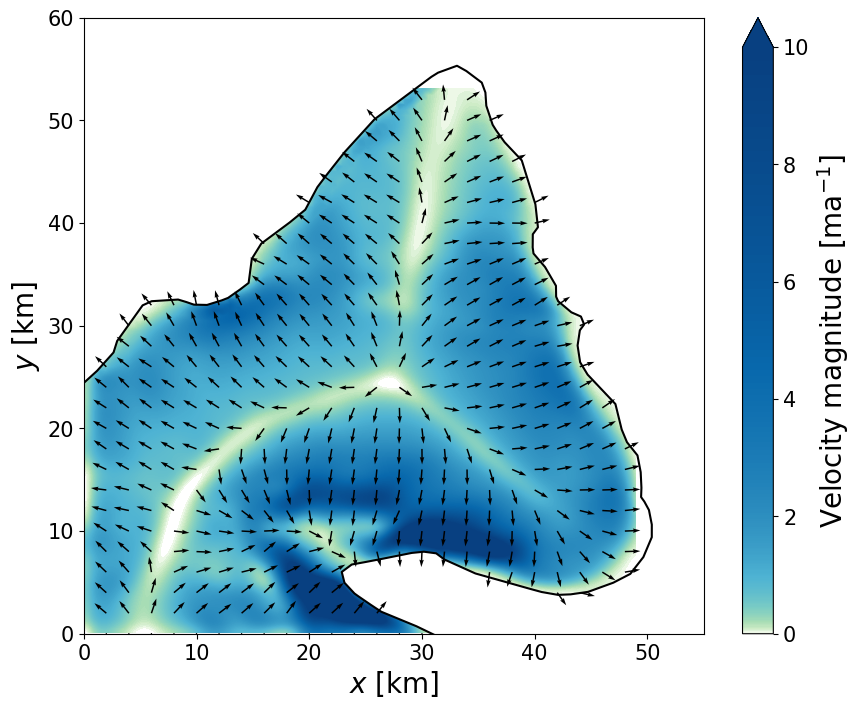

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
levels1 = np.linspace(0,10,500)
CS = ax.contourf(grid_x/1000-770, grid_y/1000-1960, vel_mag, levels=levels1, cmap=plt.cm.GnBu, locator=ticker.LogLocator(), extend='max')

skip1 = (slice(None, None, 20), slice(None, None, 20))
ax.quiver(grid_x[skip1]/1000-770, grid_y[skip1]/1000-1960, vel_x_norm[skip1], vel_y_norm[skip1], scale=40)
ax.plot(data_GL_reduced['X']/1000-770, data_GL_reduced['Y']/1000-1960, color='black')
ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
ax.tick_params(axis='both', labelsize=15)
cbar = fig.colorbar(CS, ticks=[0, 2, 4, 6, 8, 10])
cbar.set_label('Velocity magnitude [ma$^{-1}$]', size=20)
cbar.ax.tick_params(labelsize=15)
ax.set_xlim([0, 55])
ax.set_ylim([0, 60])
ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
fig.savefig('HammarryggenVelocity.jpg', format='jpg', dpi=700, bbox_inches = "tight")



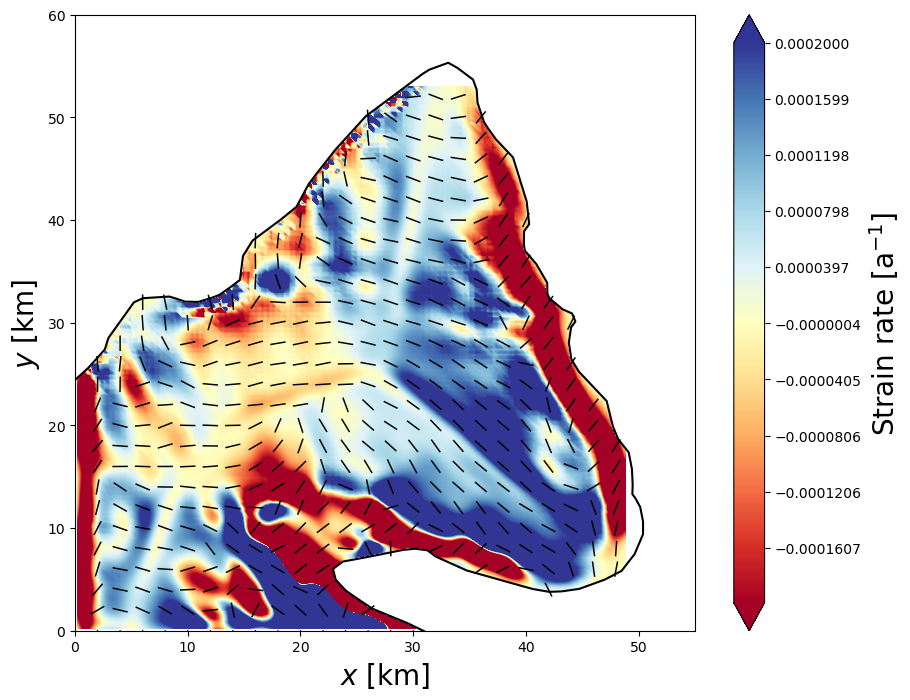

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#levels2 = np.linspace(-0.001,0.001,500)
levels2 = np.linspace(-0.0002,0.0002,500)
CS = ax.contourf(grid_x/1000-770, grid_y/1000-1960, e_total_1, levels=levels2, cmap=plt.cm.RdYlBu, extend='both')
#CS = ax.contourf(grid_x, grid_y, e_total_1, levels=levels2, cmap=plt.cm.GnBu, locator=ticker.LogLocator(), extend='max')
ax.set_xlim([0, 55])
ax.set_ylim([0, 60])
skip2 = (slice(None, None, 20), slice(None, None, 20))
#ax.quiver(grid_x[skip1]/1000-770, grid_y[skip1]/1000-1960, vel_x_norm[skip1], vel_y_norm[skip1], scale=40)
ax.quiver(grid_x[skip2]/1000-770, grid_y[skip2]/1000-1960, v1_max_20[skip2], v2_max_20[skip2], scale=40, pivot='mid', headlength=0, headwidth=1)
ax.plot(data_GL_reduced['X']/1000-770, data_GL_reduced['Y']/1000-1960, color='black')
ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
cbar = fig.colorbar(CS)
cbar.set_label('Strain rate [a$^{-1}$]', size=20)
#ax.tick_params(color='w', labelcolor='w')
fig.savefig('HammarryggenStrainRate.jpg', format='jpg', dpi=700, bbox_inches = "tight")


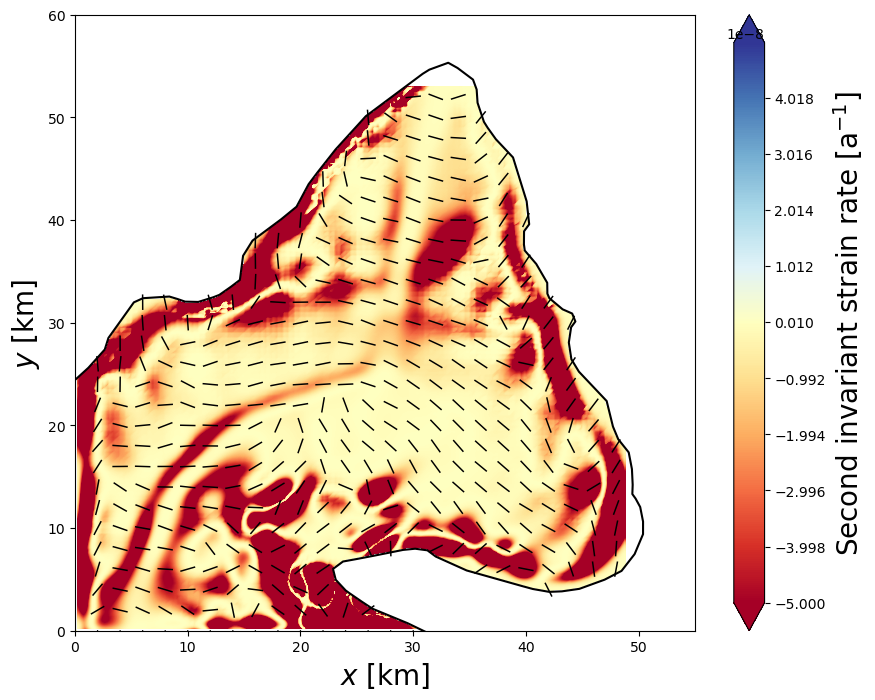

In [24]:
# Plot second strain rate tensor invariant

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#levels2 = np.linspace(-0.001,0.001,500)
levels2 = np.linspace(-0.00000005,0.00000005,500)
CS = ax.contourf(grid_x/1000-770, grid_y/1000-1960, e_2nd_inv_1, levels=levels2, cmap=plt.cm.RdYlBu, extend='both')
#CS = ax.contourf(grid_x, grid_y, e_2nd_inv_1, cmap=plt.cm.GnBu, locator=ticker.LogLocator(), extend='max')
#CS = ax.contourf(grid_x, grid_y, e_2nd_inv_1, cmap=plt.cm.GnBu, extend='max')
ax.set_xlim([0, 55])
ax.set_ylim([0, 60])
skip2 = (slice(None, None, 20), slice(None, None, 20))
#ax.quiver(grid_x[skip1]/1000-770, grid_y[skip1]/1000-1960, vel_x_norm[skip1], vel_y_norm[skip1], scale=40)
ax.quiver(grid_x[skip2]/1000-770, grid_y[skip2]/1000-1960, v1_max_20[skip2], v2_max_20[skip2], scale=40, pivot='mid', headlength=0, headwidth=1)
ax.plot(data_GL_reduced['X']/1000-770, data_GL_reduced['Y']/1000-1960, color='black')
ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
cbar = fig.colorbar(CS)
cbar.set_label('Second invariant strain rate [a$^{-1}$]', size=20)
#ax.tick_params(color='w', labelcolor='w')
fig.savefig('HammarryggenStrainRate2ndInvariant.jpg', format='jpg', dpi=700, bbox_inches = "tight")



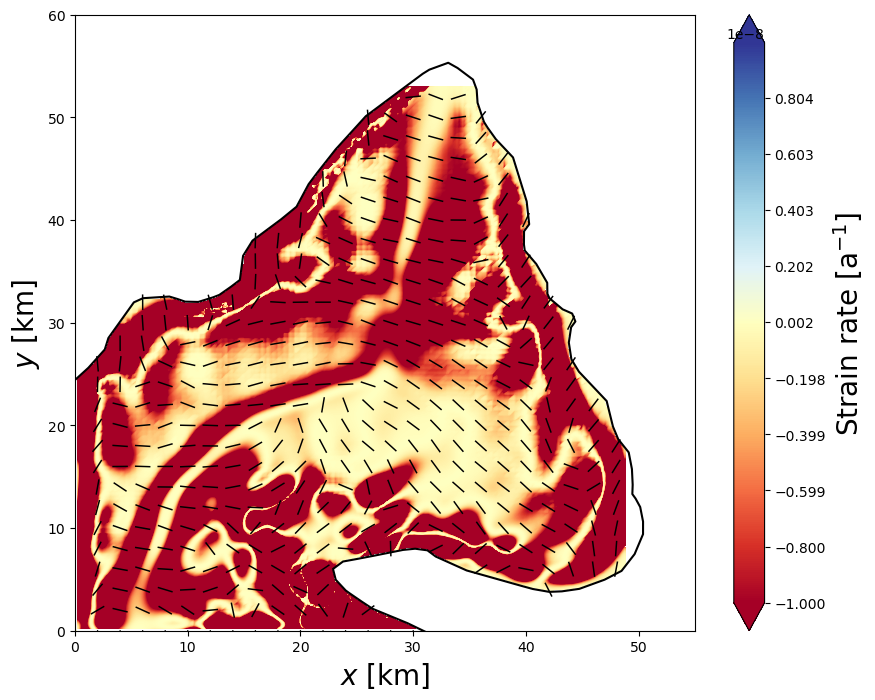

In [25]:
# Plot the dilation rate (i.e. the change in "area" of the strain rate tensor)  dil_rate_1

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#levels2 = np.linspace(-0.001,0.001,500)
levels2 = np.linspace(-0.00000001,0.00000001,500)
CS = ax.contourf(grid_x/1000-770, grid_y/1000-1960, dil_rate_1, levels=levels2, cmap=plt.cm.RdYlBu, extend='both')
#CS = ax.contourf(grid_x, grid_y, e_2nd_inv_1, cmap=plt.cm.GnBu, locator=ticker.LogLocator(), extend='max')
#CS = ax.contourf(grid_x, grid_y, e_2nd_inv_1, cmap=plt.cm.GnBu, extend='max')
ax.set_xlim([0, 55])
ax.set_ylim([0, 60])
skip2 = (slice(None, None, 20), slice(None, None, 20))
#ax.quiver(grid_x[skip1]/1000-770, grid_y[skip1]/1000-1960, vel_x_norm[skip1], vel_y_norm[skip1], scale=40)
ax.quiver(grid_x[skip2]/1000-770, grid_y[skip2]/1000-1960, v1_max_20[skip2], v2_max_20[skip2], scale=40, pivot='mid', headlength=0, headwidth=1)
ax.plot(data_GL_reduced['X']/1000-770, data_GL_reduced['Y']/1000-1960, color='black')
ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
cbar = fig.colorbar(CS)
cbar.set_label('Strain rate [a$^{-1}$]', size=20)
#ax.tick_params(color='w', labelcolor='w')
fig.savefig('HammarryggenStrainRateDilationRate.jpg', format='jpg', dpi=700, bbox_inches = "tight")



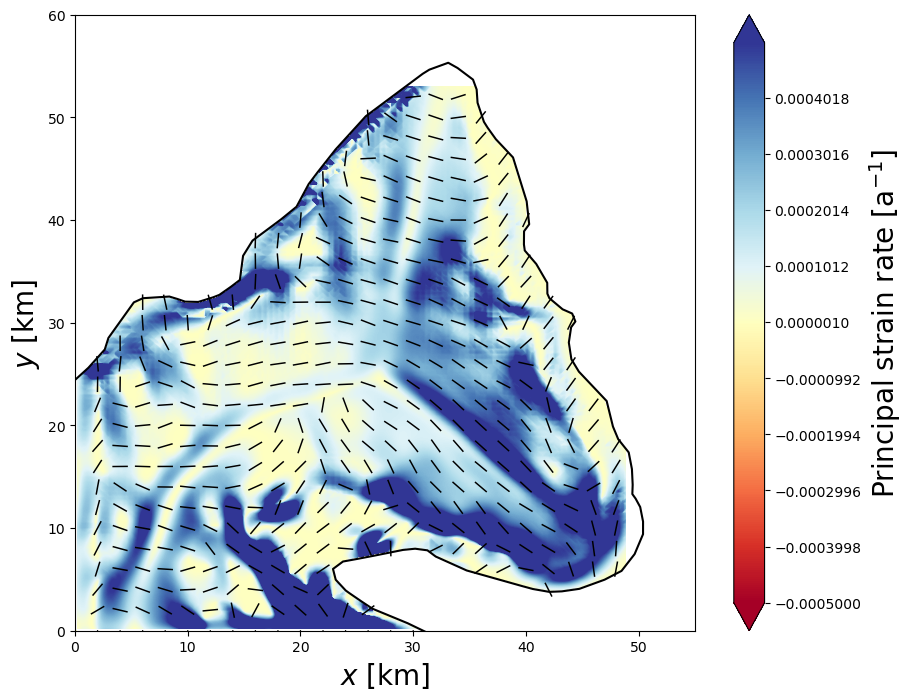

In [26]:
# Plot the magnitude of the larger eigenvalue

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#levels2 = np.linspace(-0.001,0.001,500)
levels2 = np.linspace(-0.0005,0.0005,500)
CS = ax.contourf(grid_x/1000-770, grid_y/1000-1960, e_max_1, levels=levels2, cmap=plt.cm.RdYlBu, extend='both')
#CS = ax.contourf(grid_x, grid_y, e_2nd_inv_1, cmap=plt.cm.GnBu, locator=ticker.LogLocator(), extend='max')
#CS = ax.contourf(grid_x, grid_y, e_2nd_inv_1, cmap=plt.cm.GnBu, extend='max')
ax.set_xlim([0, 55])
ax.set_ylim([0, 60])
skip2 = (slice(None, None, 20), slice(None, None, 20))
#ax.quiver(grid_x[skip1]/1000-770, grid_y[skip1]/1000-1960, vel_x_norm[skip1], vel_y_norm[skip1], scale=40)
ax.quiver(grid_x[skip2]/1000-770, grid_y[skip2]/1000-1960, v1_max_20[skip2], v2_max_20[skip2], scale=40, pivot='mid', headlength=0, headwidth=1)
ax.plot(data_GL_reduced['X']/1000-770, data_GL_reduced['Y']/1000-1960, color='black')
ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
cbar = fig.colorbar(CS)
cbar.set_label('Principal strain rate [a$^{-1}$]', size=20)
#ax.tick_params(color='w', labelcolor='w')
fig.savefig('HammarryggenStrainRateE1.jpg', format='jpg', dpi=700, bbox_inches = "tight")


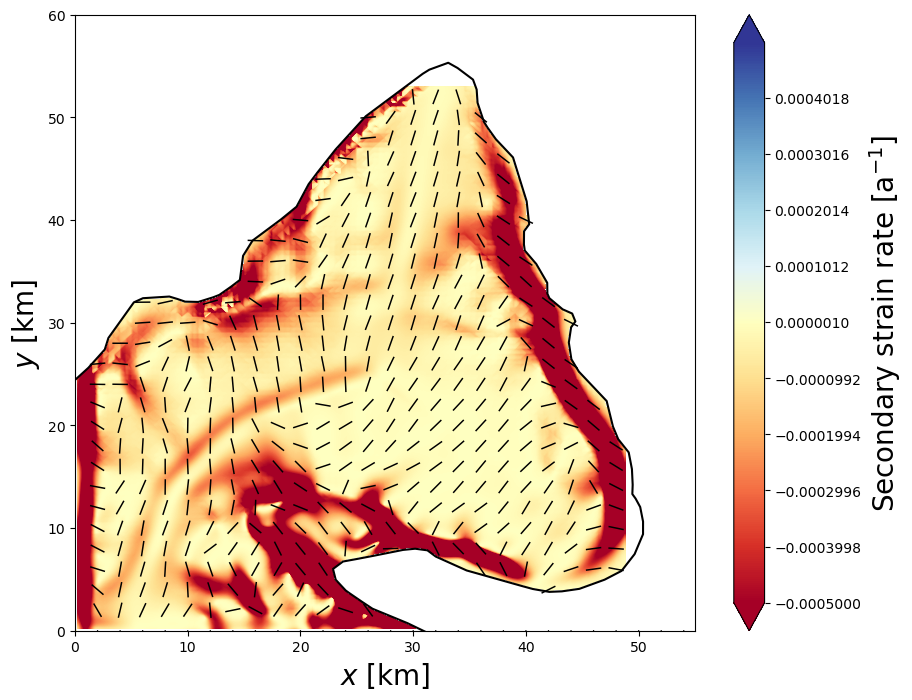

In [32]:
# Plot the magnitude of the smaller eigenvalue

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#levels2 = np.linspace(-0.001,0.001,500)
levels3 = np.linspace(-0.0005,0.0005,500)
CS = ax.contourf(grid_x/1000-770, grid_y/1000-1960, e_min_1, levels=levels3, cmap=plt.cm.RdYlBu, extend='both')
#CS = ax.contourf(grid_x, grid_y, e_2nd_inv_1, cmap=plt.cm.GnBu, locator=ticker.LogLocator(), extend='max')
#CS = ax.contourf(grid_x, grid_y, e_2nd_inv_1, cmap=plt.cm.GnBu, extend='max')
ax.set_xlim([0, 55])
ax.set_ylim([0, 60])
skip2 = (slice(None, None, 20), slice(None, None, 20))
#ax.quiver(grid_x[skip1]/1000-770, grid_y[skip1]/1000-1960, vel_x_norm[skip1], vel_y_norm[skip1], scale=40)
ax.quiver(grid_x[skip2]/1000-770, grid_y[skip2]/1000-1960, v1_min_20[skip2], v2_min_20[skip2], scale=40, pivot='mid', headlength=0, headwidth=1)
ax.plot(data_GL_reduced['X']/1000-770, data_GL_reduced['Y']/1000-1960, color='black')
ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
cbar = fig.colorbar(CS)
cbar.set_label('Secondary strain rate [a$^{-1}$]', size=20)
#ax.tick_params(color='w', labelcolor='w')
fig.savefig('HammarryggenStrainRateE2.jpg', format='jpg', dpi=700, bbox_inches = "tight")


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_30908/2329582647.py:6: RuntimeWarning: divide by zero encountered in log
  CS = ax.contourf(grid_x/1000-770, grid_y/1000-1960, np.log(e_ratio_1), levels=levels3, cmap=plt.cm.RdYlBu, extend='both')
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_30908/2329582647.py:6: RuntimeWarning: invalid value encountered in log
  CS = ax.contourf(grid_x/1000-770, grid_y/1000-1960, np.log(e_ratio_1), levels=levels3, cmap=plt.cm.RdYlBu, extend='both')


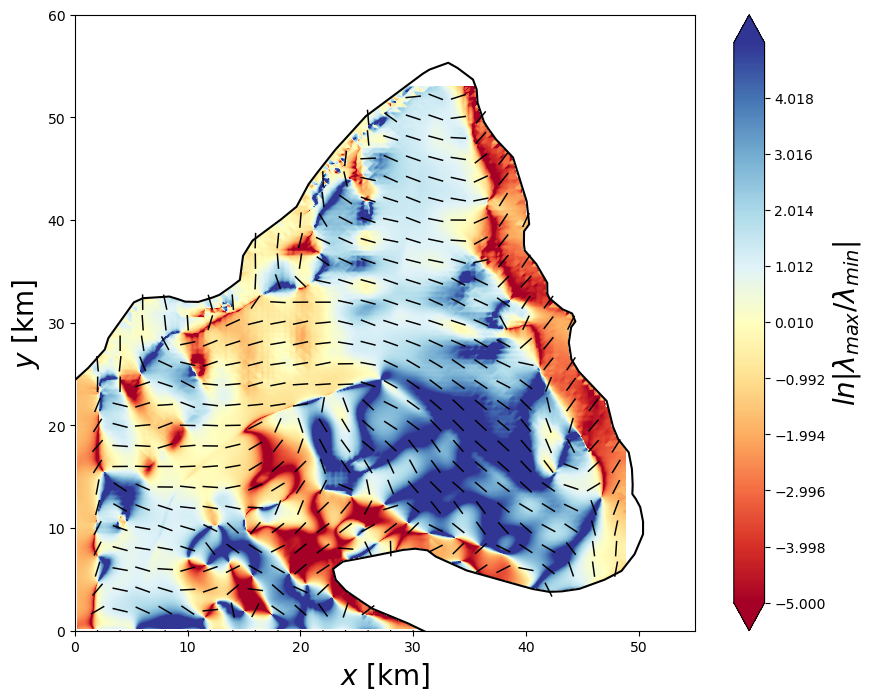

In [41]:
# Plot \lambda_min / \lambda_max

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#levels2 = np.linspace(-0.001,0.001,500)
levels3 = np.linspace(-5.0,5.0,500)
CS = ax.contourf(grid_x/1000-770, grid_y/1000-1960, np.log(e_ratio_1), levels=levels3, cmap=plt.cm.RdYlBu, extend='both')
#CS = ax.contourf(grid_x, grid_y, e_2nd_inv_1, cmap=plt.cm.GnBu, locator=ticker.LogLocator(), extend='max')
#CS = ax.contourf(grid_x, grid_y, e_2nd_inv_1, cmap=plt.cm.GnBu, extend='max')
ax.set_xlim([0, 55])
ax.set_ylim([0, 60])
skip2 = (slice(None, None, 20), slice(None, None, 20))
#ax.quiver(grid_x[skip1]/1000-770, grid_y[skip1]/1000-1960, vel_x_norm[skip1], vel_y_norm[skip1], scale=40)
ax.quiver(grid_x[skip2]/1000-770, grid_y[skip2]/1000-1960, v1_max_20[skip2], v2_max_20[skip2], scale=40, pivot='mid', headlength=0, headwidth=1)
ax.plot(data_GL_reduced['X']/1000-770, data_GL_reduced['Y']/1000-1960, color='black')
ax.set_xlabel(r'$x$ [km]', size=20)
ax.set_ylabel(r'$y$ [km]', size=20)
cbar = fig.colorbar(CS)
cbar.set_label(r'$ln|\lambda_{max} / \lambda_{min}|$', size=20)
#ax.tick_params(color='w', labelcolor='w')
fig.savefig('HammarryggenStrainRateLogRatio.jpg', format='jpg', dpi=700, bbox_inches = "tight")

In [34]:
np.log(0.0)

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_30908/2834539276.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(0.0)


-inf

In [35]:
# Create a resolution of 2.5km

skip = (slice(None, None, 25), slice(None, None, 25))
vx25 = vel_x[skip]
vy25 = vel_y[skip]
vmag25 = vel_mag[skip]
xcoord25 = grid_x[skip]
ycoord25 = grid_y[skip]


In [36]:
# Create a csv of the velocity data

# Flatten each array

vx = vx25.flatten()
vy = vy25.flatten()
vmag = vmag25.flatten()
xcoord = xcoord25.flatten()
ycoord = ycoord25.flatten()

HammarryggenVelData = np.array([xcoord, ycoord, vx, vy, vmag ])
HammarryggenVelData = HammarryggenVelData.T
np.savetxt("HammarryggenVelData25.csv", HammarryggenVelData, delimiter=",",  header="xcoord,ycoord,vx,vy,vmag", comments='')
